In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import subprocess
import cv2

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
import sys
print(sys.modules['keras_retinanet'].__file__)
print(sys.modules['keras_resnet'].__file__)
print(sys.modules['keras'].__file__)

/home/kai/.local/lib/python3.5/site-packages/keras_retinanet-0.0.1-py3.5.egg/keras_retinanet/__init__.py
/home/kai/.local/lib/python3.5/site-packages/keras_resnet/__init__.py
/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/__init__.py


In [3]:
# model = keras.models.load_model('../snapshots/resnet50_csv_06-10kbatch.h5', custom_objects=custom_objects)
# model = keras.models.load_model('../snapshots/circuit_resnet50_csv_49.h5', custom_objects=custom_objects)
# model = keras.models.load_model('../snapshots/circuit_resnet50_csv_02.h5', custom_objects=custom_objects)
model = keras.models.load_model('/media/kai/Data1/robotPrototype/calibration/modelSnapshots/circuit_resnet50_csv_02.h5', custom_objects=custom_objects)
# print(model.summary())

/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


## configure the features for the circuit

In [4]:
x0 = 994
y0 = 606

features = [["leftHole", 276-x0, 767-y0, 20],
           ["rightCircuit", 481-x0, 761-y0, 20],
           ["topHole", 1030-x0, 358-y0, 20],
           ["batteryContact", 791-x0, 463-y0, 30],
           ["16GBLabelCorner", 723-x0, 690-y0, 30],
           ["socketRF", 774-x0, 757-y0, 20],
           ["socketC", 899-x0, 417-y0, 30]]

numOrigins = 13
numFeatures = numOrigins + len(features)

print(numFeatures)

20


In [5]:
import numpy as np
import math

initAngle = np.zeros(numFeatures, dtype=float)
index = numOrigins
for feature in features:
    initAngle[index] = math.atan2(feature[2],feature[1]) * 180.0/math.pi
    index = index+1

print(initAngle)

[   0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.          167.36139804  163.18811005  -81.74056202 -144.83785097
  162.7784927   145.53571231 -116.68618372]


In [6]:

def get2DPose(inFile):
    image = cv2.imread(inFile)
    print(image.shape)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = validation_generator.preprocess_image(image)
    print(image.shape)
    image, scale = validation_generator.resize_image(image)
    print(image.shape)
    print(scale)
    
    # process image
    start = time.time()
    detections = None
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    # correct for image scale
    detections[0, :, :4] /= scale
    
    b = None
    foundTarget = False
    angle = None
    centerX = np.zeros(numFeatures, dtype=int)
    centerY = np.zeros(numFeatures, dtype=int)

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5 or centerX[label] != 0:
            continue
            
        b = detections[0, idx, :4].astype(int)
        if label <= 12:
            foundTarget = True
            originX = (b[0]+b[2])/2
            originY = (b[1]+b[3])/2
            angle = int(validation_generator.label_to_name(label)[8:])

           
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

        centerX[label] = (b[2]+b[0])/2
        centerY[label] = (b[3]+b[1])/2
        print(label, centerX[label], centerY[label], score)
        
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    if not foundTarget:
        return -999, -999, -999
    
    
    print("origin and angle", originX, originY, angle)
    
    totalAngle = 0.0
    totalCount = 0
    if not foundTarget:
        angleAvg = angle
    else:
        for labelID in range(numOrigins+1, numFeatures, 1):
            if centerX[labelID] != 0 and centerY[labelID] != 0:
                featureAngle = (math.atan2(centerY[labelID] - originY, centerX[labelID] -originX)) * 180.0 / math.pi - initAngle[labelID]
                if featureAngle < -180:
                    featureAngle = featureAngle + 360
                elif featureAngle > 180:
                    featureAngle = 360 - featureAngle
                print("featureAngle:", labelID, centerX[labelID], centerY[labelID], featureAngle)
                totalAngle = totalAngle + featureAngle
                totalCount = totalCount + 1
    
        angleAvg = totalAngle / totalCount
    print("returning", originX, originY, angleAvg)
    return originX, originY, angleAvg

In [7]:

def getMatchedOrigin(inFile, angle, xCenter, yCenter):
    origin_length = 25 # length on either side of origin
    method = eval('cv2.TM_CCOEFF_NORMED')   
    
    command = "convert origin.png -distort SRT '{},{},1,{},{},{}' -alpha off tmp_origin_out.png".format(origin_length, origin_length, angle, origin_length, origin_length)
    print(command)
    result = os.system(command)
    print(result)
    cropped_length = 40

    img = cv2.imread(inFile)
    template = cv2.imread('tmp_origin_out.png')

    img = img[yCenter-cropped_length:yCenter+cropped_length, xCenter-cropped_length:xCenter+cropped_length]
    # plt.imsave("tmp_cropped.png", img)

    res = cv2.matchTemplate(img, template, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    print("max_val: ", max_val)
    print("max_loc: ", max_loc)
    print("max_center: ", max_loc[0]+origin_length, max_loc[1]+origin_length)

    xResult = xCenter-cropped_length+max_loc[0]+origin_length
    yResult = yCenter-cropped_length+max_loc[1]+origin_length
    print(xResult, yResult)
    return xResult, yResult



In [8]:
# feature values for "/home/kai/work/data/180116ConnectC/c{}.png"
connectorCFeatures = [[92,36,-30.5],
           [89,39,-27.7],
           [71,61,-9.25],
           [51,73,1.0],
           [83,48, -20.15],
           [101,14,-41.0],
           [60,73,0],
           [-15,37,58],
           [94,26,-34.4]]

connectorCCropBox = [-250,-300, 100, -100]

In [19]:
def getFeatureOffsetFromOrigin(inFeatures, cropBox, inFileName, originX, originY, angle, debug=False):
    command = "{},{} {}".format(originX, originY, angle)
    outFileName = "tmp_straightened.png"
    subprocess.run(["convert", inFileName, "-distort", "SRT", command, "-alpha", "off", outFileName])

    img = cv2.imread(outFileName, cv2.IMREAD_GRAYSCALE)
    if debug:
        print("command: ", command)
        print("cropBox: ", cropBox)
        print("image shape: ", img.shape)
        
    img_cropped = img[originY+cropBox[1]:originY+cropBox[3], originX+cropBox[0]:originX+cropBox[2]]
    #img_cropped = img
    if debug:
        print(img_cropped.shape)

    bestVal = 100000

    for index in range(0,len(inFeatures)):
        filename = "/media/kai/Data1/robotPrototype/calibration/180116ConnectC/c{}.png".format(index)
        cTemplate = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        w, h = cTemplate.shape[::-1]

        result = cv2.matchTemplate(img_cropped, cTemplate, cv2.TM_SQDIFF_NORMED)
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
        if debug:
            print(index, minVal)

        if minVal < bestVal:
            bestVal = minVal
            bestLoc = minLoc
            bestIndex = index
            bestResult = result

    top_left = bestLoc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    if debug:
        print("best match: ", bestIndex, top_left, bottom_right)
    resultX = cropBox[0]+top_left[0]+inFeatures[bestIndex][0]
    resultY = cropBox[1]+top_left[1]+inFeatures[bestIndex][1]
    resultAngle = inFeatures[bestIndex][2]
    
    # return pose relative to origin
    resultX = -0.0001618 * resultX
    resultY = -0.0001627 * resultY
    resultZ = -0.004
#    rX = 0.139
#    rY = -0.35
    rX = 0
    rY = 0
    rZ = resultAngle * math.pi/180.0
    if debug:
        print("result (pixels offset from origin): ({}, {}) , angle = {}".format(resultX, resultY, resultAngle))
    
    if debug:
        filename = "/home/kai/work/data/180116ConnectC/c{}.png".format(bestIndex)
        cTemplate = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        cv2.rectangle(img_cropped,top_left, bottom_right, 255, 3)
        plt.subplot(121),plt.imshow(img_cropped,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(cTemplate,cmap = 'gray')
        plt.title('template image'), plt.xticks([]), plt.yticks([])
        plt.show()
        
    return "({}, {}, {}, {}, {}, {})\n".format(resultX, resultY, resultZ, rX, rY, rZ)

# Create Server to respond to identification request

In [10]:
import socket
import time

HOST = "192.168.1.116" #The remote host
PORT = 3001 # The same port as used by the server
print("Starting 2d id program")

Starting 2d id program


In [11]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/calibration/MLRotation/annotation6Tiny.txt',
                '/media/kai/Data1/robotPrototype/calibration/MLRotation/classname6.txt',
                val_image_data_generator,
                batch_size=10
            )

returnVal = None

Waiting for connections...
Connected
received: acquireCircuitOrigin
acquiring...
(956, 1276, 3)
(956, 1276, 3)
(600, 801, 3)
0.6276150627615062
processing time:  0.06536746025085449
16 336 202 0.999967
19 444 159 0.999916
17 271 430 0.99958
6 537 345 0.996059
15 578 96 0.908898
14 26 500 0.644593


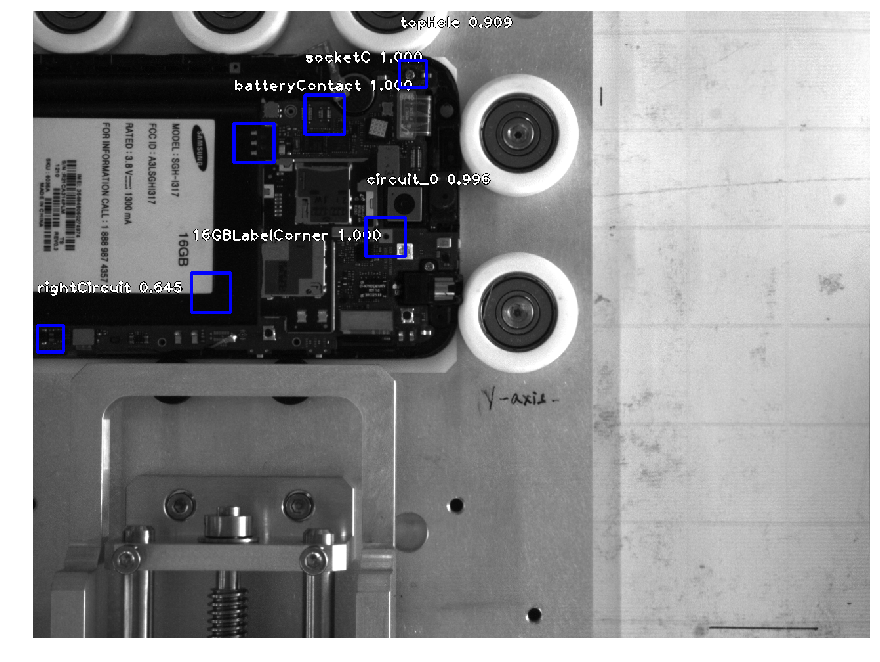

origin and angle 537.0 345.0 0
featureAngle: 14 26 500 -0.062067333529
featureAngle: 15 578 96 1.09090564854
featureAngle: 16 336 202 0.267525531522
featureAngle: 17 271 430 -0.499714484729
featureAngle: 19 444 159 0.121132545768
returning 537.0 345.0 0.183556381515
initialPos:      537.0 345.0 0.183556381515
convert origin.png -distort SRT '25,25,1,0,25,25' -alpha off tmp_origin_out.png
0
max_val:  0.9179028868675232
max_loc:  (16, 14)
max_center:  41 39
538 344
fine tuned Pos:  538 344 0.183556381515
sending:    0.0020,   0.1230,  -0.0240,  0.000,  0.000,  0.003
Waiting for connections...
Connected
received: getCircuitOrigin
(  0.0020,   0.1230,  -0.0240,  0.000,  0.000,  0.003)

Waiting for connections...
Connected
received: getCircuitOrigin
(  0.0020,   0.1230,  -0.0240,  0.000,  0.000,  0.003)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  538,344 -0.18355638151545292
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.29248765

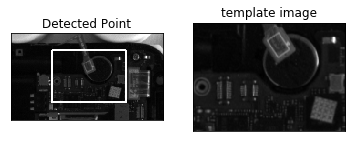

(0.0100316, 0.0382345, -0.004, 0, 0, -0.6003932626860493)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  538,344 -0.18355638151545292
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.29248765110969543
1 0.24264541268348694
2 0.40243470668792725
3 0.4997926354408264
4 0.2683275043964386
5 0.42156845331192017
6 0.4557885527610779
7 0.6014877557754517
8 0.22681422531604767
best match:  8 (94, 39) (262, 159)
result (pixels offset from origin): (0.0100316, 0.0382345) , angle = -34.4


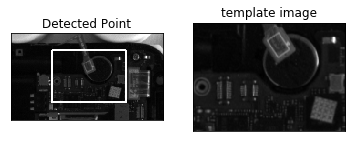

(0.0100316, 0.0382345, -0.004, 0, 0, -0.6003932626860493)

Waiting for connections...
Connected
received: acquireCircuitOrigin
acquiring...
(956, 1276, 3)
(956, 1276, 3)
(600, 801, 3)
0.6276150627615062
processing time:  0.07193565368652344
16 336 202 0.999967
19 444 158 0.99993
17 271 429 0.999616
6 537 345 0.995475
15 579 97 0.888158
14 25 500 0.771551


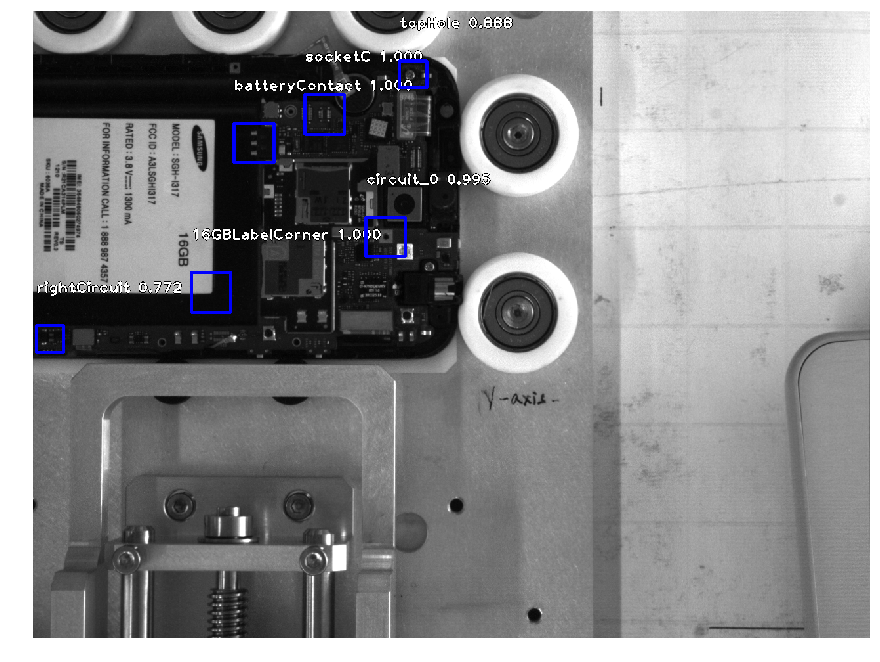

origin and angle 537.0 345.0 0
featureAngle: 14 25 500 -0.0309781428109
featureAngle: 15 579 97 1.35267677449
featureAngle: 16 336 202 0.267525531522
featureAngle: 17 271 429 -0.304061073633
featureAngle: 19 444 158 0.243821393607
returning 537.0 345.0 0.305796896635
initialPos:      537.0 345.0 0.305796896635
convert origin.png -distort SRT '25,25,1,0,25,25' -alpha off tmp_origin_out.png
0
max_val:  0.9151446223258972
max_loc:  (16, 14)
max_center:  41 39
538 344
fine tuned Pos:  538 344 0.305796896635
sending:    0.0020,   0.1230,  -0.0240,  0.000,  0.000,  0.005
Waiting for connections...
Connected
received: getCircuitOrigin
(  0.0020,   0.1230,  -0.0240,  0.000,  0.000,  0.005)

Waiting for connections...
Connected
received: getCircuitOrigin
(  0.0020,   0.1230,  -0.0240,  0.000,  0.000,  0.005)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  538,344 -0.3057968966345925
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.18372744

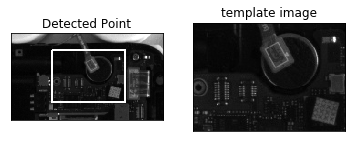

(0.010517, 0.0366075, -0.004, 0, 0, -0.5323254218582705)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  538,344 -0.3057968966345925
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.1837274432182312
1 0.24185708165168762
2 0.5011221766471863
3 0.5135355591773987
4 0.3645676374435425
5 0.3985331058502197
6 0.48819616436958313
7 0.604213297367096
8 0.19071480631828308
best match:  0 (93, 39) (261, 159)
result (pixels offset from origin): (0.010517, 0.0366075) , angle = -30.5


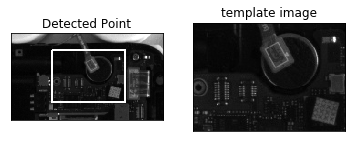

(0.010517, 0.0366075, -0.004, 0, 0, -0.5323254218582705)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  538,344 -0.3057968966345925
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.1837274432182312
1 0.24185708165168762
2 0.5011221766471863
3 0.5135355591773987
4 0.3645676374435425
5 0.3985331058502197
6 0.48819616436958313
7 0.604213297367096
8 0.19071480631828308
best match:  0 (93, 39) (261, 159)
result (pixels offset from origin): (0.010517, 0.0366075) , angle = -30.5


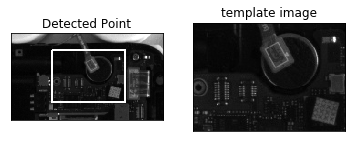

(0.010517, 0.0366075, -0.004, 0, 0, -0.5323254218582705)

Waiting for connections...
Connected
received: acquireCircuitOrigin
acquiring...
(956, 1276, 3)
(956, 1276, 3)
(600, 801, 3)
0.6276150627615062
processing time:  0.07029080390930176
16 312 231 0.999985
19 423 195 0.999918
17 235 454 0.99949
7 504 386 0.995855
15 562 141 0.746703
18 275 522 0.628584


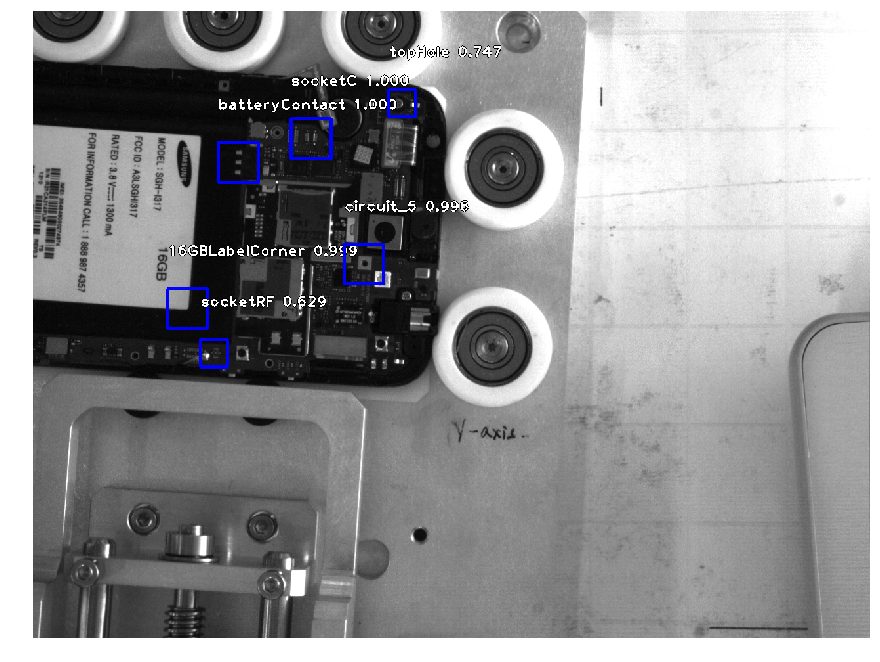

origin and angle 504.0 386.0 5
featureAngle: 15 562 141 5.05926580242
featureAngle: 16 312 231 3.75149962045
featureAngle: 17 235 454 3.03501300653
featureAngle: 18 275 522 3.75878469424
featureAngle: 19 423 195 3.70517107287
returning 504.0 386.0 3.8619468393
initialPos:      504.0 386.0 3.8619468393
convert origin.png -distort SRT '25,25,1,4,25,25' -alpha off tmp_origin_out.png
0
max_val:  0.9331144094467163
max_loc:  (16, 14)
max_center:  41 39
505 385
fine tuned Pos:  505 385 3.8619468393
sending:    0.0074,   0.1163,  -0.0240,  0.000,  0.000,  0.067
Waiting for connections...
Connected
received: getCircuitOrigin
(  0.0074,   0.1163,  -0.0240,  0.000,  0.000,  0.067)

Waiting for connections...
Connected
received: getCircuitOrigin
(  0.0074,   0.1163,  -0.0240,  0.000,  0.000,  0.067)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  505,385 -3.8619468393013987
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.32996758818626404
1

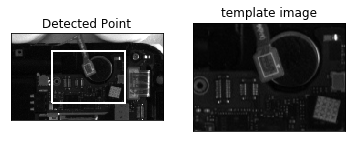

(0.0119732, 0.0344924, -0.004, 0, 0, -0.3516838442768574)

Waiting for connections...
Connected
received: getConnectorCOffset
command:  505,385 -3.8619468393013987
cropBox:  [-250, -300, 100, -100]
image shape:  (956, 1276)
(200, 350)
0 0.32996758818626404
1 0.24438466131687164
2 0.411578506231308
3 0.4983377456665039
4 0.22741596400737762
5 0.4607376456260681
6 0.47506284713745117
7 0.5876370072364807
8 0.27612394094467163
best match:  4 (93, 40) (261, 160)
result (pixels offset from origin): (0.0119732, 0.0344924) , angle = -20.15


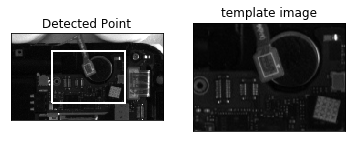

(0.0119732, 0.0344924, -0.004, 0, 0, -0.3516838442768574)

Waiting for connections...


In [ ]:
finishedLoop = False
inFileName = ''
xPixel = 0
yPixel = 0
a = 0.0

while finishedLoop == False:
    print("Waiting for connections...")
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((HOST, PORT)) # Bind to the port 
    s.listen(5) # Now wait for client connection.
    c, addr = s.accept() # Establish connection with client.
    print("Connected")
    foundError = False
    finishedInner = False
    while foundError == False and finishedInner == False:
        try:
            msg = c.recv(40).decode("utf-8").strip()
            if msg != "":
                print("received: " + msg)
            time.sleep(1)
            if msg == "acquireCircuitOrigin":
                print("acquiring...")
                inFileName = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
                xPixel,yPixel,a = get2DPose(inFileName)
                if xPixel == -999:
                    returnVal = "None Found"
                else:    
                    print("initialPos:     ", xPixel, yPixel, a)
                    xPixel, yPixel = getMatchedOrigin(inFileName, int(round(a)), int(round(xPixel)), int(round(yPixel)))
                    print("fine tuned Pos: ", xPixel, yPixel, a)
                    x = (-0.1618 * xPixel + 89.08)/1000.0
                    y = (-0.1627 * yPixel + 178.933)/1000.0
                    z = -24.0/1000.0
                    rx = 0.0
                    ry = 0.0
                    rz = a / 180.0 * math.pi
                    returnVal = "{0:8.4f}, {1:8.4f}, {2:8.4f}, {3:6.3f}, {4:6.3f}, {5:6.3f}".format(x, y, z, rx, ry, rz)
                print("sending: ", returnVal)
                c.send(returnVal.encode())
                finishedInner = True
            elif msg == "getCircuitOrigin":
                returnString = "({})\n".format(returnVal)
                c.send(returnString.encode())
                print(returnString)
                finishedInner = True
            elif msg == "getConnectorCOffset":
                result = getFeatureOffsetFromOrigin(connectorCFeatures, connectorCCropBox, inFileName, xPixel, yPixel, -a, debug=True)
                c.send(result.encode())
                print(result)
                finishedInner = True
            elif msg == "end":
                finishedLoop = True
                finishedInner = True
        except socket.error as socketError:
            print(socketError)
            foundError = True
    c.close()
    s.close()

In [18]:
c.close()
s.close()

# Tests

In [ ]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotation6Tiny.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classname6.txt',
                val_image_data_generator,
                batch_size=10
            )

In [ ]:
#testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
#testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/resultImg6/out_330_460_-10.png"
#testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/resultImg4/out_330_460_-10.png"
testFile = "/media/kai/Data1/robotPrototype/data/180115WideAngleCalibration/wideAngleImage1.undistorted.png"

result = get2DPose(testFile)
# result = get2DPose("\\\\KAI-LAPTOP\\Users\\kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
# result = get2DPose("C:\\Users\\Kai\\study\\robot_prototype\\pyCameraCalibration\\result\\raw\\img65.jpg.png")
print(testFile, int(round(result[2])), int(round(result[0])), int(round(result[1])))

xResult, yResult = getMatchedOrigin(testFile, int(round(result[2])), int(round(result[0])), int(round(result[1])))
print (xResult, yResult)

In [ ]:
# testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/resultImg4/out_400_200_25.png"
#testFile = "/media/kai/Data1/robotPrototype/data/180109OriginInferenceIssue/undistorted.png"
#testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"

result = get2DPose(testFile)

In [ ]:

xResult, yResult = getMatchedOrigin(testFile, -5, 500, 385)